# Learning to Localize with TEM

The key assertion that is examined by this project is that *agents should learn a concept of space through their actions, and then use that space to remember and plan*. The assertion is based in part on the function of the hippocampus in animal navigation, memory, and cognition. Whittington _et al._ published a model of the hippocampus called the [Tolman Eichenbaum Machine](https://www.sciencedirect.com/science/article/pii/S009286742031388X) with a later update using transformer attention for memory called [TEM-t](https://arxiv.org/pdf/2112.04035). I have discussed this method in detail [on my blog](https://embodiedlanguage.substack.com/p/the-tolman-eichenbaum-machine). The approach in the current project is a variation of this scheme.

Our goal will be to develop a closed-loop, needs-driven controller on top of an auto-localization mechanism like TEM. By "auto-localization", I mean localization through based strictly on the sensory input and action output, without any external observation of the explicit or true position. This concept is deeply akin to SLAM for robotics, and in fact, the approach here may be considered a form of neural SLAM.

Before working with a goal-driven controller, however, we will first develop the localization machinery and verify that it is working. We will do this by using a controller that traverses the space with random contents. During these traversals, we will train our localization models. Then we will inspect how the model has learned to represent space and make sure that this representation is acceptable.

## Localization Problem Statement

Localization is to be based purely on sensor and actuator data. Thus we suppose that we have a sensor sequence $x = (x_1, x_2, \ldots, x_t, \ldots)$ and an action sequence $a = (a_1, a2, \ldots, a_t, \ldots)$. We will use $x_{<t}$ for the sensor data up to but not including $x_t$, and $x_{\leq t}$ for sensor data up to and including $x_t$. The action $a_t$ is selected on the basis of $x_t$ and hence comes _after_ $x_t$. 

We want to infer a latent sequence of locations $\ell = (\ell_1, \ell_2, ..., \ell_t, \ldots)$ such that $\ell_t$ represents the location in space where the agent observed $x_t$ and responded with action $a_t$. 

We will infer $\ell_t$ as a random variable in a probabilistic system, which means we will train a probability density $q_\phi$ defined so that
$$
q_\phi(\ell \mid x, a) \,\,=\,\, \prod_t \,q_\phi\left(\ell_t \,\left\vert\,x_t,\,\vphantom{x^{x^x}} M(\ell_{<t},x_{<t}), \,a_{\leq t}, \,\ell_{t-1}\right.\right).
$$
This model will be trained using a variation autoencoder (VAE), which means we will also train a reverse generative model $p_\theta$ as
$$
p_\theta(x, \ell \mid a) \,\,=\,\, \prod_t \,p_\theta\left(x_t \,\left\vert\, \ell_t, \,M(\ell_{<t},x_{<t})\vphantom{x^{x^x}}\right.\right) \, p_\theta(\ell_t \mid \ell_{t-1}, \,a_t),
$$
where the function $M(\ell_{<t}, x_{<t})$ in both models is a memory containing pairs of (location, sensory data) for all times preceding $t$.

The component of the model that pertains to updating actions is $p_\theta(\ell_t \mid \ell_{t-1}, \,a_t)$. For TEM-t in particular, the authors choose the inference model to be
$$
\ell_t = \sigma(W_{a_t}\ell_{t-1})
$$
for nonlinear activation function $\sigma$ (they use ReLU) and learned weight matrix $W_{a_t} = W(a_t)$. From a theoretical standpoint, this is problematic because the outputs are forced to be non-negative, but the underlying distribution is assumed to be Gaussian, and hence supported across the reals. In practice, it may not matter, but this can be revisited.

As is normal for a VAE, we will train $p_\theta$ and $q_\phi$ to model the same distribution as closely as possible by maximizing the Evidence Lower Bound (ELBo),
$$
\mathcal{L} \,\,=\,\, \mathbb{E}_{q_\phi}\left[\log \,\frac{p_\theta(x, \ell \mid a)}{q_\phi(\ell \mid x, a)}\right]
$$
which, as usual, breaks down in two key terms after factoring the conditionals,
$$
\mathcal{L} \,\,=\,\, \sum_t \left\{\vphantom{x^{x^{x^{x^{x^{x^x}}}}}}\mathbb{E}_{q_\phi}\left[\vphantom{x^{x^{x^{x^{x^x}}}}}\log p_\theta(x_t \mid\ldots)\right]  \,\,-\,\, \mathrm{E}_{q_\phi}\left[\log \,\frac{q_\phi(\ell_t \mid \ldots)}{p_\theta\left(\ell_t \mid \ldots \right)}\right]\right\},
$$
where the first term maximizes the probability of the training data under the generative model, and the second term is the Kullback-Leibler divergence of the generation model from the inference model:
$$
\mathcal{L} \,\,=\,\, \sum_t \left\{\vphantom{x^{x^{x^{x^{x^{x^x}}}}}}\mathbb{E}_{q_\phi}\left[\vphantom{x^{x^{x^{x^{x^x}}}}}\log p_\theta(x_t \mid\ldots)\right]  \,\,-\,\, D_{KL}\left({q_\phi(\ell_t \mid \ldots)} \,\left\|\, \vphantom{x^{x^{x^{x^{x^x}}}}}{p_\theta\left(\ell_t \mid \ldots \right)}\right.\right)\right\}.
$$

The authors of the TEM paper present the model as a VAE, but their actual training seems to be a deterministic variation on the above, assuming standard normal distributions on each component, with sign reversed for minimization:
$$
\mathcal{L}_{\text{det}} = \sum_t \left\{\vphantom{x^{x^{x^{x^{x^{x^x}}}}}}\mathbb{E}_{q_\phi}\left[
    \frac{1}{2}\left\|\vphantom{x^{x^x}} x_t - \text{M.read}(\ell_t)\right\|^2
\,\,-\,\,
    \frac{1}{2}\left\|\vphantom{x^{x^x}} \ell_t - \text{M.sample}(x_t)\right\|^2 
\,\,+\,\, 
    \frac{1}{2}\left\|\vphantom{x^{x^x}} \ell_t - \sigma\left(W_{a_t} \ell_{t-1}\right)\right\|^2 
\right] \right\}
$$
where $\text{M.read}$ and $\text{M.sample}$ are memory reads (by key) and memory sample (by value). See [Developing a Spatial Map](./map_testing.ipynb) for details. Note that
$$
\ell_t = \frac{1}{2} \left(\vphantom{x^{x^x}}\sigma\left(W_{a_t} \ell_{t-1}\right) + \text{M.sample}(x_t)\right)
$$
minimizes the difference in $\mathcal{L}_{\text{alt}}$ above.

Let's make a diagram of the model to show the interactions:




In [1]:
from graphviz import Digraph

def tem_vae_timeslice():
    g = Digraph('G', format='svg')
    g.attr(rankdir='LR', splines='spline', nodesep='0.5', ranksep='0.6')
    node = lambda n, **kw: g.node(n, **({'shape':'ellipse', 'fontsize':'12'} | kw))

    # Styles
    obs = {'style':'filled', 'fillcolor':'#e8f0fe'}    # observed (x, a)
    lat = {'style':'filled', 'fillcolor':'#fff7e6'}    # latent (ℓ)
    det = {'shape':'box', 'style':'rounded,filled', 'fillcolor':'#eef7ee'}  # deterministic (M, factors)

    # Plates (clusters)
    with g.subgraph(name='cluster_tminus') as c:
        c.attr(label='t-1', color='#cccccc')
        c.node('l_tm1', 'ℓ_{t−1}', **lat)

    with g.subgraph(name='cluster_t') as c:
        c.attr(label='t', color='#cccccc')
        c.node('x_t', 'x_t', **obs)
        c.node('a_t', 'a_t', **obs)
        c.node('l_t', 'ℓ_t', **lat)
        c.node('M_t', 'M(ℓ_{<t}, x_{<t})', **det)

    with g.subgraph(name='cluster_tplus') as c:
        c.attr(label='t+1', color='#cccccc')
        c.node('l_tp1', 'ℓ_{t+1}', **lat)

    # Generative edges pθ:
    g.edge('l_t', 'x_t', label='pθ(x_t | ℓ_t, M)', fontsize='10')
    g.edge('M_t', 'x_t', color='#5b8', fontsize='10')
    g.edge('l_tm1', 'l_t', label='pθ(ℓ_t | ℓ_{t−1}, a_t)', fontsize='10')
    g.edge('a_t', 'l_t', color='#5b8')

    # Inference info qφ (dashed helpers into ℓ_t)
    g.edge('x_t', 'l_t', style='dashed', color='#888', label='qφ', fontsize='10')
    g.edge('M_t', 'l_t', style='dashed', color='#888')
    g.edge('l_tm1', 'l_t', style='dashed', color='#888')

    # Temporal link forward (light)
    g.edge('l_t', 'l_tp1', style='invis')  # keep layout tidy

    return g

tem_vae_timeslice()


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

## Upgrading TEM's Spatial Content

Now we will develop the variant of the TEM model in `tree_world.models.tem`. This is not strictly either TEM or TEM-t, because it uses the memory described in [Developing a Spatial Map](./map_testing.ipynb) instead of a Hopfield net or a standard transformer layer. But it is the same model in spirit.

We begin with a component for updating localization based on action. As noted above, TEM-t uses $\ell_t = \sigma(W_{a_t}\ell_{t-1})$. But this assumes discrete actions (_e.g._, north, south, east, west) with one distinct matrix $W_a$ per action. Furthermore, the grid sizes explored in the TEM paper are quite small, 11x11 at the largest. We will work with continuous actions in larger spaces, so we will need to think more deeply about what $\ell_t$ represents and what $W_a$ is intended to do.

The purpose of TEM is to model the grid cells of the entorhinal cortex. A grid cell fires when the animal is at a particular spot in its internal map. This means that $\ell_t$ should be a sparse vector of high dimension, and could be organized either as a vector (for 1-D maps) or a matrix (for 2-D maps), or even as a 3-tensor (for 3-D). We should assume that actions are _local_, transferring activity among neighboring grid cells but leaving distant grid cells untouched. Yet we should also want our actions to be _translation invariant_, applying action equally at various points in space. These two considerations point towards an implementation with a convolutional layer over a pixel-like space.

To represent the space of tree world in this pixelated way, consider a spatial grid of size $S \times S$ for integer $S > 0$, that is, let $\ell \in \mathbb{R}^{S\times S} \approxeq \mathbb{R}^{S^2}$, and suppose $S = 2R + 1$ for another integer $R$, so that the bounds of the space are $[-R, R]$ in each dimension. Let us assume a spatial scale $\gamma > 0$, and let us interpret $\ell_{ij}$ to represent the point $\left(\vphantom{x^{x^x}}\gamma (i - R), \gamma (j-R)\right)$ in $\mathbb{R}^2$.

Under this interpretation, $\ell$ becomes a probability distribution over $\mathbb{R}^2$ representing the agent's belief about its location in $\mathbb{R}^2$. 

For our basic actions in Tree World, we have $a_t \in \mathbb{R}^2$ performing a translation in the underlying space. While we might want more complicated actions later, this choice makes our modeling straightforward for now. First, we can define a continuous 2-D convolution kernel
$$
\hat{W}[a](h,w) = \left\{\begin{array}{cc}
   1 & \text{if $a = (-w,-h)$} \\
   0 & \text{otherwise}
\end{array}\right.,
$$
which, when convolved with a location belief map, will translate the location beliefs according to the vector $a$.

Now we need to replace $\hat{W}[a]$ into a discrete kernel of size $S \times S$. Rather than write down the math, let's just give the code:

In [ ]:
import torch
import torchvision


def map_index_to_space(indices, R, gamma):
    return gamma * (indices - R)

def map_space_to_preindex(x, R, gamma):
    return x / gamma + R

def make_2d_translation_kernel(a, gamma=1.0, filter_size=5, 
                               apply_gaussian_blur=False, gaussian_blur_kernel_size=3, gaussian_blur_sigma=1):
    """
    Make a discrete translation kernel for action a in a space of size S.
    """
    if a.ndim == 1:
        a = a.unsqueeze(0)

    assert a.ndim == 2
    assert a.shape[1] == 2
    assert filter_size % 2 == 1, "filter_size must be odd so that the center is well-defined"

    channels = a.shape[0]
    K = (filter_size - 1) // 2

    # note: we negate a here because we want to translate in the direction of a -- positive would move the opposite direction
    actual = map_space_to_preindex(-a, K, gamma)
    upper = torch.ceil(actual)
    lower = torch.floor(actual)
    fraction = (actual - lower) / (upper - lower)
    fraction_mask = (upper - lower) < 1e-8
    fraction = torch.where(fraction_mask, torch.ones_like(fraction), fraction)

    # note: we reverse the indices because typical image indexing is (y, x) but our actions are (x, y)
    outer_indices = torch.arange(channels)
    upper_indices = torch.clamp(upper.long(), 0, filter_size - 1)
    lower_indices = torch.clamp(lower.long(), 0, filter_size - 1)

    action_filter = torch.zeros(channels, channels, filter_size, filter_size)
    
    fraction_x = fraction[..., 0]
    fraction_y = fraction[..., 1]

    fraction_x_opp = torch.where(fraction_mask[..., 0], torch.ones_like(fraction_x), 1 - fraction_x)
    fraction_y_opp = torch.where(fraction_mask[..., 1], torch.ones_like(fraction_y), 1 - fraction_y)

    action_filter[outer_indices, outer_indices, upper_indices[..., 1], upper_indices[..., 0]] = fraction_y * fraction_x
    action_filter[outer_indices, outer_indices, lower_indices[..., 1], lower_indices[..., 0]] = fraction_y_opp * fraction_x_opp
    action_filter[outer_indices, outer_indices, upper_indices[..., 1], lower_indices[..., 0]] = fraction_y * fraction_x_opp
    action_filter[outer_indices, outer_indices, lower_indices[..., 1], upper_indices[..., 0]] = fraction_y_opp * fraction_x

    if apply_gaussian_blur:
        import torchvision
        kernel_size = [gaussian_blur_kernel_size] * 2
        gaussian_sigma = [gaussian_blur_sigma] * 2
        action_filter = torchvision.transforms.functional.gaussian_blur(action_filter, kernel_size, gaussian_sigma)

    return action_filter


print(f"action [1, 1]")
action_filter = make_2d_translation_kernel(torch.tensor([1, 1]))
for row in action_filter.squeeze():
    print(" ".join(f"{x:.2f}" for x in row))

print()
print(f"batch size 2, actions [[1, 0], [-0.4, -0.25]]")
action_filter = make_2d_translation_kernel(torch.tensor([[1, 0], [-0.4, -0.25]]))
print("------[1, 0]------")
for row in action_filter[0,0]:
    print(" ".join(f"{x:.2f}" for x in row))

print()
print(f"Check zeros: {torch.norm(action_filter[0, 1, :, :])} = 0.0")
print()
print("------[-0.5, -0.5]------")
for row in action_filter[1,0]:
    print(" ".join(f"{x:.2f}" for x in row))

print()
print(f"Check zeros: {torch.norm(action_filter[1, 0, :, :])} = 0.0")



action [1, 1]
0.00 0.00 0.00 0.00 0.00
0.00 1.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00

batch size 2, actions [[1, 0], [-0.4, -0.25]]
------[1, 0]------
0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00
0.00 1.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00

Check zeros: 0.0 = 0.0

------[-0.5, -0.5]------
0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00

Check zeros: 0.0 = 0.0


grid.shape: torch.Size([101, 101, 2])
gauss_img.shape: torch.Size([101, 101])


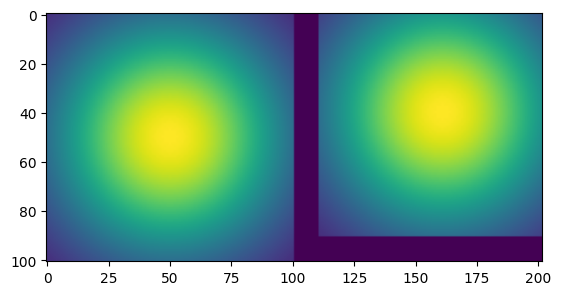

In [ ]:
def apply_2d_translation(
    location_belief, action, gamma=1.0, filter_size=5, 
    apply_gaussian_blur=False, gaussian_blur_kernel_size=5, gaussian_blur_sigma=2
):
    # location belief is a tensor of shape (batch_size, height, width)
    kernel = make_2d_translation_kernel(
        action, 
        gamma=gamma, 
        filter_size=filter_size, 
        apply_gaussian_blur=apply_gaussian_blur, 
        gaussian_blur_kernel_size=gaussian_blur_kernel_size,
        gaussian_blur_sigma=gaussian_blur_sigma
    )
    convolved = torch.nn.functional.conv2d(location_belief, kernel, padding=(kernel.shape[2] // 2, kernel.shape[3] // 2))
    return convolved

grid_size = 101   # R = 50
grid_points = torch.linspace(-1, 1, grid_size)
grid = torch.cartesian_prod(grid_points, grid_points).view(grid_size, grid_size, 2)  # (101, 101, 2), [-1, 1]^2
print(f"grid.shape: {grid.shape}")

gauss_img = torch.exp(-grid.pow(2).sum(dim=-1))
print(f"gauss_img.shape: {gauss_img.shape}")
shifted_gauss_img = apply_2d_translation(gauss_img.unsqueeze(0), torch.tensor([10, 10]), filter_size=31).squeeze(0)

# combine the images, initial on the left, translated on the right -- flip the height dim so that 0,0 is in the bottom left
matplotlib_img = torch.cat([gauss_img, shifted_gauss_img], dim=1).flip(dims=(0,))

from matplotlib import pyplot as plt

plt.imshow(matplotlib_img)


As the example above shows, the function `make_2d_translation_kernel` will output a kernel with shape (batch_size, batch_size, filter_height, filter_width) that can be applied as a 2d convolution to an image of size (batch_size, height, width) in `channel_first` format, and, when appropriately padded, will produce the same shape output, translated by action $a$. In the example above, we move the image by 10 steps up and to the right in a space that has $S=200$ width.

We can also shift a batch size of two images with different actions. Below, we shift the top row 10 to the right, and the bottom row 10 down and 3 to the left.

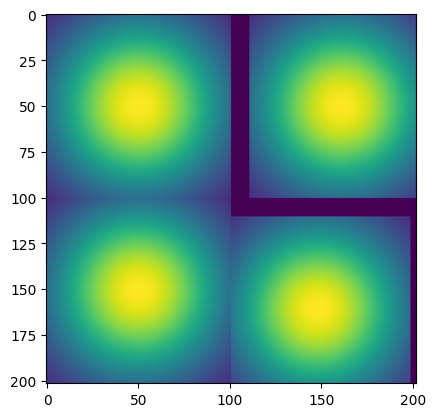

In [30]:
# now shift two images at once
action = torch.tensor([[10, 0], [-3, -10]])
images = gauss_img.unsqueeze(0).repeat(2, 1, 1)
shifted_images = apply_2d_translation(images, action, filter_size=31)

matplotlib_img = torch.cat([
    torch.cat([images[0], shifted_images[0]], dim=1).flip(dims=(0,)),
    torch.cat([images[1], shifted_images[1]], dim=1).flip(dims=(0,))
], dim=0)

plt.imshow(matplotlib_img)

With `apply_2d_translation`, we can apply a movement action $a$ to a belief about locations $\ell$. Let us call this translation $h$ and represent our new location as 
$$
\ell_t = h(\ell_{t-1}, a_t)
\quad\quad\text{in place of}\quad\quad
\ell_t = \sigma(W_{a_t} \ell_{t-1})
\quad\quad\text{above}
$$

Note that we can also use a gaussian blur to account for uncertainty in our action measurements, shown below.

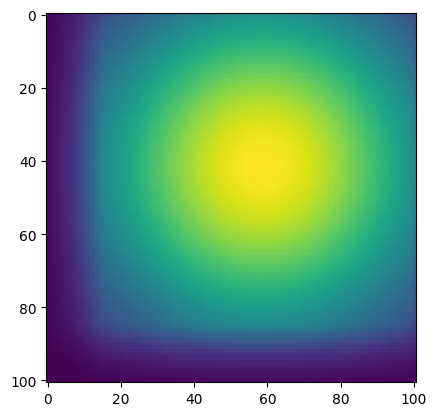

In [31]:
shifted_gauss_img = apply_2d_translation(
    gauss_img.unsqueeze(0), torch.tensor([10, 10]), filter_size=31,
    apply_gaussian_blur=True, gaussian_blur_kernel_size=25, gaussian_blur_sigma=10
).squeeze(0)

plt.imshow(shifted_gauss_img.flip(dims=(0,)))


## Revising the Memory for Location Beliefs

In [Developing a Spatial Map](./map_testing.ipynb), we developed a map keyed by locations. However, the keys were explicitly points in the location space, whereas our location beliefs $\ell_t$ is a grid of fixed locations. Our memory will be simpler if it is just a 4-tensor of shape (batch_size, height, width, sensory_dim), but this requires maintain a fixed size memory. We need to understand the cost.

Since our grid has size $S \times S$, the memory would be size $(B, S, S, D)$ where $D$ is the sensory dimension. Suppose we are willing to work with one batch at a time; then the memory requirement is $S^2D$ floats. For a large map with $S=128$ and sensory dim $D=1024$ coming from a word embedding, we end up with $2^{7 + 7 + 10 + 2} = 2^{26} = 64$ MB. This is trivial for storage, but it also represents a context length of $2^{14} = 16,384$, which requires careful implementation. 

Let us proceed nonetheless to implement our `read` and `sample` operations in this naive fashion. We'll start with `read`

In [65]:
def read_memory_grid(memory: torch.Tensor, location_belief: torch.Tensor) -> torch.Tensor:
    # we set out location belief to be a probability distribution, so we can just use the dot product
    # memory is a tensor of shape (batch_size, height, width, sensory_dim)
    # location_belief is a tensor of shape (batch_size, height, width)
    memory = memory.view(memory.shape[0], -1, memory.shape[-1])
    location_belief = location_belief.view(location_belief.shape[0], -1, 1)

    return torch.bmm(memory.transpose(1, 2), location_belief).squeeze(-1)

We'll need a world to test it in.

In [ ]:
S = 101   # grid size
D = 1024  # sensory dimension

from tree_world.simulation import TreeWorldConfig, TreeWorld, SimpleSensor
config = TreeWorldConfig()
config.embedding_dim = D
sensor = SimpleSensor.from_config(config)
world = TreeWorld.random_from_config(config)

To test `read`, we'll define `write`. We'll do it so that for a given coordinate $i,j$, 
$$
M_{t+1}[i,j] = \ell_t[i,j] \times x_t + (1-\ell_t[i,j]) \times M_t[i,j]
$$
That way, each location will be updated in accordance with the belief that the agent is at the location, and from an empty memory, the read after write will return the same value that was written. 

If an agent stays at the same place and retains the same location belief and reads the same sensor value, then over time, the value stored at each pixel will contain the sensory value. Although this would cause reads to overshoot the magnitude of the proper return, in practice the agent belief should be getting more focused over time, which the written value will reinforce. At infinite time, the agent should believe itself to be only in the location of the strongest response, which will return exactly the written sensory value.

In [88]:
def write_memory_grid(memory: torch.Tensor, location_belief: torch.Tensor, sensory_input: torch.Tensor):
    # memory is a tensor of shape (batch_size, height, width, sensory_dim)
    # location_belief is a tensor of shape (batch_size, height, width)
    # sensory_input is a tensor of shape (batch_size, sensory_dim)
    memory = memory.view(memory.shape[0], -1, memory.shape[-1])
    location_belief = location_belief.view(location_belief.shape[0], -1, 1)

    return memory * (1 - location_belief) + location_belief * sensory_input.unsqueeze(-2)


read vs. sensor: 1.4162039756774902


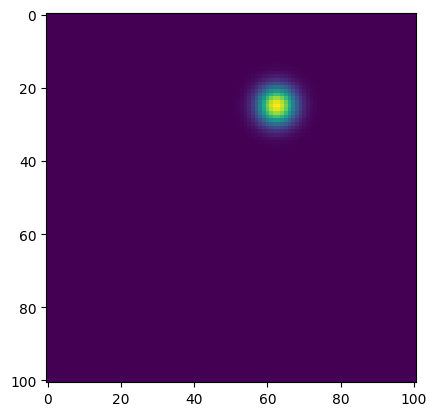

In [93]:

location_belief = torch.exp(-(grid * 10 - torch.tensor([[5, 2.5]])).pow(2).sum(dim=-1)).unsqueeze(0)
location_belief = location_belief / location_belief.sum()

memory = torch.zeros(1, S, S, D)
_, sensory_data, _ = sensor.sense(world, torch.tensor([[2.5, 5]]), None)

memory = write_memory_grid(memory, location_belief, sensory_data)
read_result = read_memory_grid(memory, location_belief).squeeze(0)

diff = torch.norm(read_result - sensory_data)
print(f"read vs. sensor: {diff.item()}")

plt.imshow(location_belief.squeeze(0).flip(dims=(0,)))


Where reading was trivial, 

In [94]:
def sample_memory_grid(
    memory: torch.Tensor, location_belief: torch.Tensor, search_key: torch.Tensor, num_samples: int = 1,
    temperature: float = 1.0, residual_probability: float = 0.1,
    gaussian_blur_kernel_size: int = 5, gaussian_blur_sigma: float = 2.0, 
) -> torch.Tensor:
    # we set out location belief to be a probability distribution, so we can just use the dot product
    # memory is a tensor of shape (batch_size, height, width, sensory_dim)
    # location_belief is a tensor of shape (batch_size, height, width)
    # search_key is a tensor of shape (batch_size, sensory_dim)
    batch_size, height, width = location_belief.shape
    memory = memory.view(batch_size, -1, memory.shape[-1])
    location_belief = location_belief.view(batch_size, -1, 1)

    key_compatibility = torch.bmm(memory, search_key.unsqueeze(-1)).squeeze(-1)
    key_probability = torch.nn.functional.softmax(temperature * key_compatibility, dim=-1)

    location_compatibility = torchvision.transforms.functional.gaussian_blur(
        location_belief.view(batch_size, 1, height, width),
        [gaussian_blur_kernel_size] * 2,
        [gaussian_blur_sigma] * 2
    ).view_as(location_belief)

    location_probability = residual_probability * location_compatibility + (1 - residual_probability)

    joint_probability = location_probability * key_probability

    locations = torch.multinomial(joint_probability, num_samples)
    locations_x = locations % width
    locations_y = locations // width

    return torch.stack([locations_x, locations_y], dim=-1)

search_key = memory[0, 0, 0]

## Implementing a TEM Module

We can use a single model to implement TEM as a pseudo-VAE; there is no good reason to maintain the inspiration of an encoder and decoder model. Instead, we need to build a module to infer $\ell_t$, populate a memory $M$, and compute the loss
$$
\mathcal{L}_{\text{det}} = \sum_t \left\{\vphantom{x^{x^{x^{x^{x^{x^x}}}}}}\mathbb{E}_{q_\phi}\left[
    \frac{1}{2}\left\|\vphantom{x^{x^x}} x_t - \text{M.read}(\ell_t)\right\|^2
\,\,-\,\,
    \frac{1}{2}\left\|\vphantom{x^{x^x}} \ell_t - \text{M.sample}(x_t)\right\|^2 
\,\,+\,\, 
    \frac{1}{2}\left\|\vphantom{x^{x^x}} \ell_t - h(\ell_{t-1}, a_t)\right\|^2 
\right] \right\}
$$
given that
$$
\ell_t = \frac{1}{2} \left[\vphantom{x^{x^x}}h(\ell_{t-1}, a_t) + \text{M.sample}(x_t)\right],
$$
this reduces to
$$
\mathcal{L}_{\text{det}} = \frac{1}{2}\sum_t \left\{\vphantom{x^{x^{x^{x^{x^{x^x}}}}}}\mathbb{E}_{q_\phi}\left[
    \left\|\vphantom{x^{x^x}} x_t - \text{M.read}(\ell_t)\right\|^2
\right] \right\}
$$
which will be minimized when the memory contains the right sensory data ($\text{M.read}(\ell_t) = x_t$) at the location determined by checking the memory ($\text{M.sample}(x_t)$) and predicting from the last position ($h(\ell_{t-1}, a_t)$).

With this in mind, and using the memory as a parameter, we can implement TEM as follows.

In [95]:
import math
from tree_world.models.memory import BidirectionalMemory

class TEM2d(torch.nn.Module):
    def __init__(self, 
        grid_size: int, sensory_dim: int, embed_dim: int, batch_size: int = 1, 
        grid_extent: float = 1000.0, max_action_norm: float = 5.0
    ):
        super().__init__()
        self.grid_size = grid_size        # S
        self.grid_extent = grid_extent    # how far across on each side, in "real world" units
        self.grid_scale = grid_extent / (grid_size - 1)  # gamma
        self.action_filter_size = 2 * int(math.ceil(action_scale)) + 1
 
        # create the memory
        location_dim = 2
        self.memory = BidirectionalMemory(
            location_dim,
            sensory_dim,
            embed_dim,
            batch_size=batch_size,
            max_memory_size=grid_size**2,
        )

    def forward(self, last_location_belief: torch.Tensor, action: torch.Tensor, sensory_input: torch.Tensor):
        if last_location_belief is None:
            last_location_belief = torch.ones(self.batch_size, self.grid_size, self.grid_size) / self.grid_size**2

        # estimate the new location belief
        inferred_location_belief = apply_2d_translation(
            last_location_belief,
            action,
            gamma=self.grid_scale,
            filter_size=self.action_filter_size,
        )

        sampled_location_belief = self.memory.sample(sensory_input)

        # combine the two
        location_belief = (inferred_location_belief + sampled_location_belief) / 2

        # additional ... not expected from the math, but turns location_belief into a probability distribution
        location_belief = (
            location_belief / location_belief.view(location_belief.shape[0], -1).sum(dim=-1).view_as(location_belief)
        )

        # estimate the sensory input from the location belief
        estimated_sensory_input = self.memory.read(location_belief)

        # compute the loss
        loss = (sensory_input - estimated_sensory_input).pow(2).mean()

        # update the memory
        self.memory.write(location_belief, sensory_input)

        return location_belief, sampled_location_belief, loss
    

        
